#  目的
largeを使って学習する

In [1]:
# path setting
EXP_NAME = "e056-1-use-large"
MODEL_NAME = "microsoft/deberta-v3-large"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

NUM_FOLD = 3
FOLD = 0

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH= 512
# TRAINING_MAX_LENGTH = 768
# TRAINING_MAX_LENGTH = 1024
INFERENCE_MAX_LENGTH = 1536
SEED = 42
EPOCH = 4
LR = 2e-05
TRAIN_BS = 1 # 4 # 8
GRAD_ACC_NUM = 16
EVAL_BS = 1 # 4 # 8
SAVE_STEP = 0.1
EVAL_STEP = 0.1
LR_SCHE_TYPE = "linear"

# TRAINED_MODEL_PATH = (
#     "/notebooks/" + "automated_essay_scoring/trained_models/e016-not-use-dropout"
# )

In [2]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

In [3]:
!nvidia-smi

In [4]:
!python --version

In [5]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

# install

In [6]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

# import

In [7]:
import json
import os
import random
from typing import Optional, Tuple, Union

import polars as pl
import scipy as sp
import numpy as np
import torch
import torch.nn as nn
from functools import partial
import wandb
from datasets import DatasetDict, Value, concatenate_datasets, load_dataset
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    DebertaV2PreTrainedModel,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.deberta_v2.modeling_deberta_v2 import (
    ContextPooler,
    StableDropout,
    DebertaV2Model,
)

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.40.1"
assert datasets.__version__ == "2.19.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [12]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

'wandb'

# Fold Load

In [13]:
with open(f"{DATA_PATH}/essay_id_fold_by_s_sl_g_p_only_train_dict.json") as f:
    essay_id_fold_only_train = json.load(f)

with open(f"{DATA_PATH}/essay_id_fold_by_s_sl_g_p_only_persuade_dict.json") as f:
    essay_id_fold_only_persuade = json.load(f)

# Data Import

In [14]:
train_dataset = (
    load_dataset(
        "csv",
        data_files=f"{DATA_PATH}/train.csv",
        split="train",
    )
    .map(lambda x: {"flag": "original"})
    .map(lambda x: {"fold": essay_id_fold_only_train[x["essay_id"]]}, num_proc=NUM_PROC)
    .rename_column("score", "labels")
)

train_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/17307 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/17307 [00:00<?, ? examples/s]

Dataset({
    features: ['essay_id', 'full_text', 'labels', 'flag', 'fold'],
    num_rows: 17307
})

In [15]:
# 追加データ
persuade_dataset = (
    load_dataset(
        "csv",
        data_files={"train": f"{DATA_PATH}/persuade_w_is_tr_con_as_num.csv"},
        split="train",
    )
    .filter(lambda x: not x["is_train_contains"], num_proc=NUM_PROC)
    .select_columns(["essay_id_comp", "full_text", "holistic_essay_score"])
    .rename_columns({"essay_id_comp": "essay_id", "holistic_essay_score": "score"})
    .map(lambda x: {"flag": "persuade"})
    .map(
        lambda x: {"fold": essay_id_fold_only_persuade[x["essay_id"]]},
        num_proc=NUM_PROC,
    )
    .rename_column("score", "labels")
)

persuade_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Filter (num_proc=8):   0%|          | 0/25996 [00:00<?, ? examples/s]

Map:   0%|          | 0/13125 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/13125 [00:00<?, ? examples/s]

Dataset({
    features: ['essay_id', 'full_text', 'labels', 'flag', 'fold'],
    num_rows: 13125
})

In [16]:
# データの結合
train_dataset = concatenate_datasets([train_dataset, persuade_dataset])

# intをfloatに変換
train_dataset = train_dataset.cast_column("labels", Value(dtype="float"))

Casting the dataset:   0%|          | 0/30432 [00:00<?, ? examples/s]

In [17]:
if DEBUG:
    train_dataset = train_dataset.shuffle(seed=SEED).select(range(100))
    EPOCH = 1
    SAVE_STEP = 0.5
    EVAL_STEP = 0.5

In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(
    [AddedToken("\n", normalized=False), AddedToken(" " * 2, normalized=False)]
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

In [19]:
def tokenize(examples, max_token_length: int):
    return tokenizer(
        examples["full_text"],
        max_length=max_token_length,
        truncation=True,
        padding="max_length",
    )


train_dataset = train_dataset.map(
    tokenize,
    batched=True,
    fn_kwargs={"max_token_length": TRAINING_MAX_LENGTH},
    num_proc=NUM_PROC,
)

Map (num_proc=8):   0%|          | 0/30432 [00:00<?, ? examples/s]

In [20]:
print(train_dataset)

In [21]:
# 外部データあり2
def get_train_test_split_dataset_w_external(train_dataset, fold: int):
    original_dataset = train_dataset.filter(
        lambda x: x["flag"] == "original", num_proc=NUM_PROC
    )

    external_dataset = train_dataset.filter(
        lambda x: x["flag"] != "original", num_proc=NUM_PROC
    )

    original_train_dataset = original_dataset.filter(
        lambda x: x["fold"] != fold, num_proc=NUM_PROC
    )
    original_valid_dataset = original_dataset.filter(
        lambda x: x["fold"] == fold, num_proc=NUM_PROC
    )
    external_train_dataset = external_dataset.filter(
        lambda x: x["fold"] == fold + 3, num_proc=NUM_PROC
    )

    train_test_split_dataset = DatasetDict(
        {
            "train": concatenate_datasets(
                [original_train_dataset, external_train_dataset]
            ),
            "valid": original_valid_dataset,
        }
    )

    return train_test_split_dataset


# train_test_split_dataset = get_train_test_split_dataset_w_external(train_dataset)

# Check
# assert set(train_test_split_dataset["train"]["fold"]) == {0, 1}
# assert set(train_test_split_dataset["valid"]["fold"]) == {2}

# if not DEBUG:
#     essay_id_fold_2 = {key for key, value in essay_id_fold_dict.items() if value == 2}
#     assert set(train_test_split_dataset["valid"]["essay_id"]) == essay_id_fold_2
#     assert len(set(train_test_split_dataset["valid"]["essay_id"])) == 5769

In [22]:
# https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6

        ll = cohen_kappa_score(y, X_p, weights="quadratic")
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(
            loss_partial, initial_coef, method="nelder-mead"
        )

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6
        return X_p

    @property
    def coefficients(self):
        return self.coef_["x"]


# optR = OptimizedRounder()
# optR.fit(valid_pred, valid_dataset["labels"])
# print(optR.coefficients)

# optimized = optR.predict(valid_pred, optR.coefficients)

In [23]:
def compute_metrics_for_regression_opt(eval_pred):
    predictions, labels = eval_pred

    optR = OptimizedRounder()
    optR.fit(predictions, labels)
    optimized = optR.predict(predictions, optR.coefficients)
    print(optR.coefficients)

    qwk = cohen_kappa_score(labels, optimized, weights="quadratic")
    return {"qwk": qwk}

In [24]:
# https://www.kaggle.com/code/seoyunje/aes-2-custom-deberta-with-different-header
class MeanPooling(ContextPooler):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        )
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)  # ゼロ除算を防ぐ
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [25]:
# https://dev.classmethod.jp/articles/huggingface-usage-custom-model/
# https://github.com/huggingface/transformers/blob/94b3f544a1f5e04b78d87a2ae32a7ac252e22e31/src/transformers/models/deberta_v2/modeling_deberta_v2.py#L1313
class CustomDebertaSequenceClassification(DebertaV2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        num_labels = getattr(config, "num_labels", 2)
        self.num_labels = num_labels

        self.deberta = DebertaV2Model(config)
        self.pooler = MeanPooling(config)
        output_dim = self.pooler.output_dim

        self.classifier = nn.Linear(output_dim, num_labels)
        drop_out = getattr(config, "cls_dropout", None)
        drop_out = self.config.hidden_dropout_prob if drop_out is None else drop_out
        self.dropout = StableDropout(drop_out)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.deberta.get_input_embeddings()

    def set_input_embeddings(self, new_embeddings):
        self.deberta.set_input_embeddings(new_embeddings)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.deberta(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            return_dict=return_dict,
        )

        pooled_output = self.pooler(outputs["last_hidden_state"], attention_mask)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()
            logits = logits.view(-1).to(labels.dtype)
            loss = loss_fn(logits, labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [26]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_NUM,
    eval_accumulation_steps=GRAD_ACC_NUM,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    evaluation_strategy="epoch",
    eval_steps=EVAL_STEP,
    # save_strategy="steps",
    save_strategy="epoch",
    save_steps=SAVE_STEP,
    save_total_limit=1,
    seed=SEED,
    metric_for_best_model="qwk",
    # metric_for_best_model="mse",
    warmup_ratio=0.1,
    lr_scheduler_type=LR_SCHE_TYPE,
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    greater_is_better=True,
)

In [27]:
train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'labels', 'flag', 'fold', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 30432
})

In [28]:
oofs: list[pl.DataFrame] = []

fold = FOLD
train_test_split_dataset = get_train_test_split_dataset_w_external(
    train_dataset, fold
)

# to regression
config = AutoConfig.from_pretrained(MODEL_NAME)
config.attention_probs_dropout_prob = 0.0
config.hidden_dropout_prob = 0.0
config.num_labels = 1  # REGRESSION

model = CustomDebertaSequenceClassification.from_pretrained(
    MODEL_NAME, config=config
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)
print(MODEL_NAME)
print(model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split_dataset["train"],
    eval_dataset=train_test_split_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics_for_regression,
    compute_metrics=compute_metrics_for_regression_opt,
)
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(f"{MODEL_OUTPUT_PATH}/model_fold_{fold}")
else:
    # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
    model = AutoModelForSequenceClassification.from_pretrained(
        TRAINED_MODEL_PATH,
        num_labels=1,
        problem_type="regression",
    )

    args = TrainingArguments(
        ".",
        per_device_eval_batch_size=4,
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=args,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

# INFERRENCEのMAX_TOKENに揃えるために、validを作り直す
valid_dataset = train_test_split_dataset["valid"].map(
    tokenize,
    batched=True,
    fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
    num_proc=NUM_PROC,
)

def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example

valid_pred = trainer.predict(valid_dataset).predictions.flatten()
# np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction_fold{fold}.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset_fold{fold}")

oofs.append(valid_dataset.to_polars().select(pl.col(["essay_id", "valid_pred"])))
    
oof = pl.concat(oofs)
oof.write_csv(f"{MODEL_OUTPUT_PATH}/oof.csv")

Filter (num_proc=8):   0%|          | 0/30432 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/30432 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/17307 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/13125 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Qwk
0,1.011600,0.486398,0.737975
1,0.310700,0.792829,0.710302
2,0.209200,0.594701,0.717602
3,0.052800,0.623551,0.720757


Map (num_proc=8):   0%|          | 0/7071 [00:00<?, ? examples/s]

Map:   0%|          | 0/7071 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7071 [00:00<?, ? examples/s]

In [29]:
# if TRAINING:
#     # モデルの学習
#     trainer.train()
#     # ログの保存に利用したストレージを削除
#     os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
#     # モデルの保存
#     trainer.save_model(MODEL_OUTPUT_PATH)
# else:
#     # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
#     model = AutoModelForSequenceClassification.from_pretrained(
#         TRAINED_MODEL_PATH,
#         num_labels=1,
#         problem_type="regression",
#     )

#     args = TrainingArguments(
#         ".",
#         per_device_eval_batch_size=4,
#         report_to="none",
#         fp16=True,
#     )

#     trainer = Trainer(
#         model=model,
#         args=args,
#         data_collator=data_collator,
#         tokenizer=tokenizer,
#     )

# valid_datasetの作成・保存

In [30]:
# # valid_dataset = train_test_split_dataset["valid"]
# # TRAININGをINFERRENCEでMAX_TOKENを変えるために、validを作り直す
# valid_dataset = train_dataset.filter(
#     lambda example: example["essay_id"]
#     in train_test_split_dataset["valid"]["essay_id"],
#     num_proc=NUM_PROC,
# )

# # labelsはfloatにする
# valid_dataset = valid_dataset.cast_column("labels", Value(dtype="float"))

# valid_dataset = valid_dataset.map(
#     preprocess_function,
#     batched=True,
#     fn_kwargs={"max_token_length": INFERENCE_MAX_LENGTH},
#     num_proc=NUM_PROC,
# )


# def add_valid_pred(example, idx, valid_pred):
#     example["valid_pred"] = valid_pred[idx]
#     return example


# valid_pred = trainer.predict(valid_dataset).predictions.flatten()

# np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

# valid_dataset = valid_dataset.map(
#     add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
# )

In [31]:
# valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

# CVの計算

In [32]:
oof

essay_id,valid_pred
str,f32
"""000d118""",2.376953
"""000fe60""",2.705078
"""001bdc0""",3.238281
"""0036253""",2.4609375
"""0047cb3""",2.503906
…,…
"""ffbd0b4""",2.0390625
"""ffc9095""",2.732422
"""ffd378d""",1.536133


In [33]:
train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'labels', 'flag', 'fold', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 30432
})

In [34]:
oof_with_label = oof.join(
    train_dataset.to_polars().select(pl.col(["essay_id", "labels"])),
    on="essay_id",
    how="inner",
)

In [35]:
oof_with_label

essay_id,valid_pred,labels
str,f32,f32
"""000d118""",2.376953,3.0
"""000fe60""",2.705078,3.0
"""001bdc0""",3.238281,4.0
"""0036253""",2.4609375,2.0
"""0047cb3""",2.503906,2.0
…,…,…
"""ffbd0b4""",2.0390625,2.0
"""ffc9095""",2.732422,3.0
"""ffd378d""",1.536133,2.0


In [36]:
# for regression
# def clip_valid_pred(example):
#     # 四捨五入を実施
#     example["valid_pred"] = np.clip(example["valid_pred"], 1, 6).round()
#     return example


# valid_dataset = valid_dataset.map(clip_valid_pred)

oof_with_label = oof.join(
    train_dataset.to_polars().select(pl.col(["essay_id", "labels"])),
    on="essay_id",
    how="inner",
)

cv_score = cohen_kappa_score(
    oof_with_label["labels"],
    np.clip(oof_with_label["valid_pred"], 1, 6).round(),
    weights="quadratic",
)

print(f"OOF CV Score by round: {cv_score}")

In [37]:
oof_with_label["labels"].cast(pl.Int64)

labels
i64
3
3
4
2
2
…
2
3
2


In [38]:
optR = OptimizedRounder()
optR.fit(oof_with_label["valid_pred"], oof_with_label["labels"])
print(optR.coefficients)

optimized_valid_pred = optR.predict(oof_with_label["valid_pred"], optR.coefficients)

In [39]:
np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

In [40]:
cv_score = cohen_kappa_score(
    oof_with_label["labels"], optimized_valid_pred, weights="quadratic"
)

print(f"OOF CV Score by NelderMead: {cv_score}")

In [41]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# 混同行列の計算

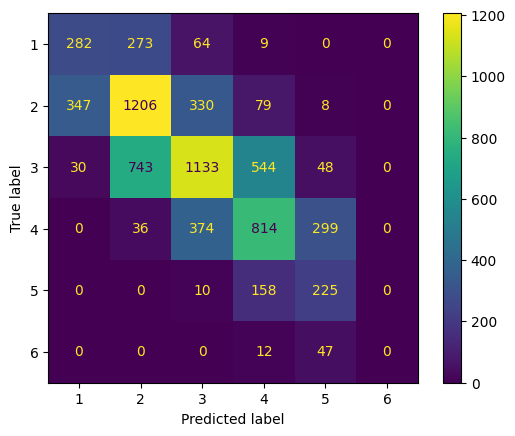

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    oof_with_label["labels"],
    optimized_valid_pred,
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# AWSへのアップロード

In [43]:
# S3へのアップロード
if not DEBUG and UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://automated-essay-scoring/trained_model/{output_name}"
    )

In [44]:
# ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e005-regression /notebooks/automated_essay_scoring/trained_models/e005-regression

# Kaggle Datasetへのupload

In [45]:
if not DEBUG and UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

# ローカルからのデータの削除

In [46]:
if not DEBUG and (UPLOAD_DATA_TO_S3 or UPLOAD_DATA_TO_KAGGLE):
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [47]:
if WANDB:
    wandb.finish()

In [48]:
print("finish Notebook!")